In [1]:
from pyspark.sql import SparkSession
import xG_preprocessing as pp
from xG_training import ModelTrainer
from xG_evaluation import ModelEvaluation
import time

In [2]:
spark = SparkSession.builder.appName("xG7").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 2000)

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/29 10:36:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Preparing the data

In [ ]:
events = spark.read.csv('hdfs://localhost:9000/big-data/events.csv',header=True,inferSchema=True,sep=';')
frames = spark.read.csv('hdfs://localhost:9000/big-data/frames.csv',header=True,inferSchema=True)

In [38]:
start_time = time.time()
shots = pp.preprocessing(events, spark)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Preprocessing took {elapsed_time:.2f} seconds.")

Preparing data took 10260 seconds.


In [ ]:
shots.write.csv('hdfs://localhost:9000/big-data/shot_data.csv',header=True)

In [ ]:
shot = spark.read.csv('hdfs://localhost:9000/big-data/shot_data.csv',header=True,inferSchema=True)

In [19]:
events.count(), frames.count(), shot.count()

(8710714, 10259434, 606620)

In [36]:
shot.show()

+------+---------+------------------+------------------+----------------+-------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+----+
|    id|player_id|   shot_location_x|   shot_location_y|distance_to_goal|         shot_angle|preferred_foot_shot|from_rp|from_fk|from_corner|header|corner_type|fk_type|pk_type|lob_technique|shot_first_time|shot_one_on_one|shot_follows_dribble|players_inside_area|acrobatic_shot| shot_statsbomb_xg|goal|
+------+---------+------------------+------------------+----------------+-------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+----+
|230964|   2711.0|              96.0| 44.63999938964844|         24.4444|  18.2713510784517

In [7]:
features = shot.columns[4:-4]

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vec = assembler.transform(shot.select(*features))
correlation_matrix = Correlation.corr(df_vec, "features").head()[0]
corr_matrix = correlation_matrix.toArray()

25/01/29 08:38:55 WARN TaskSetManager: Stage 23 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.


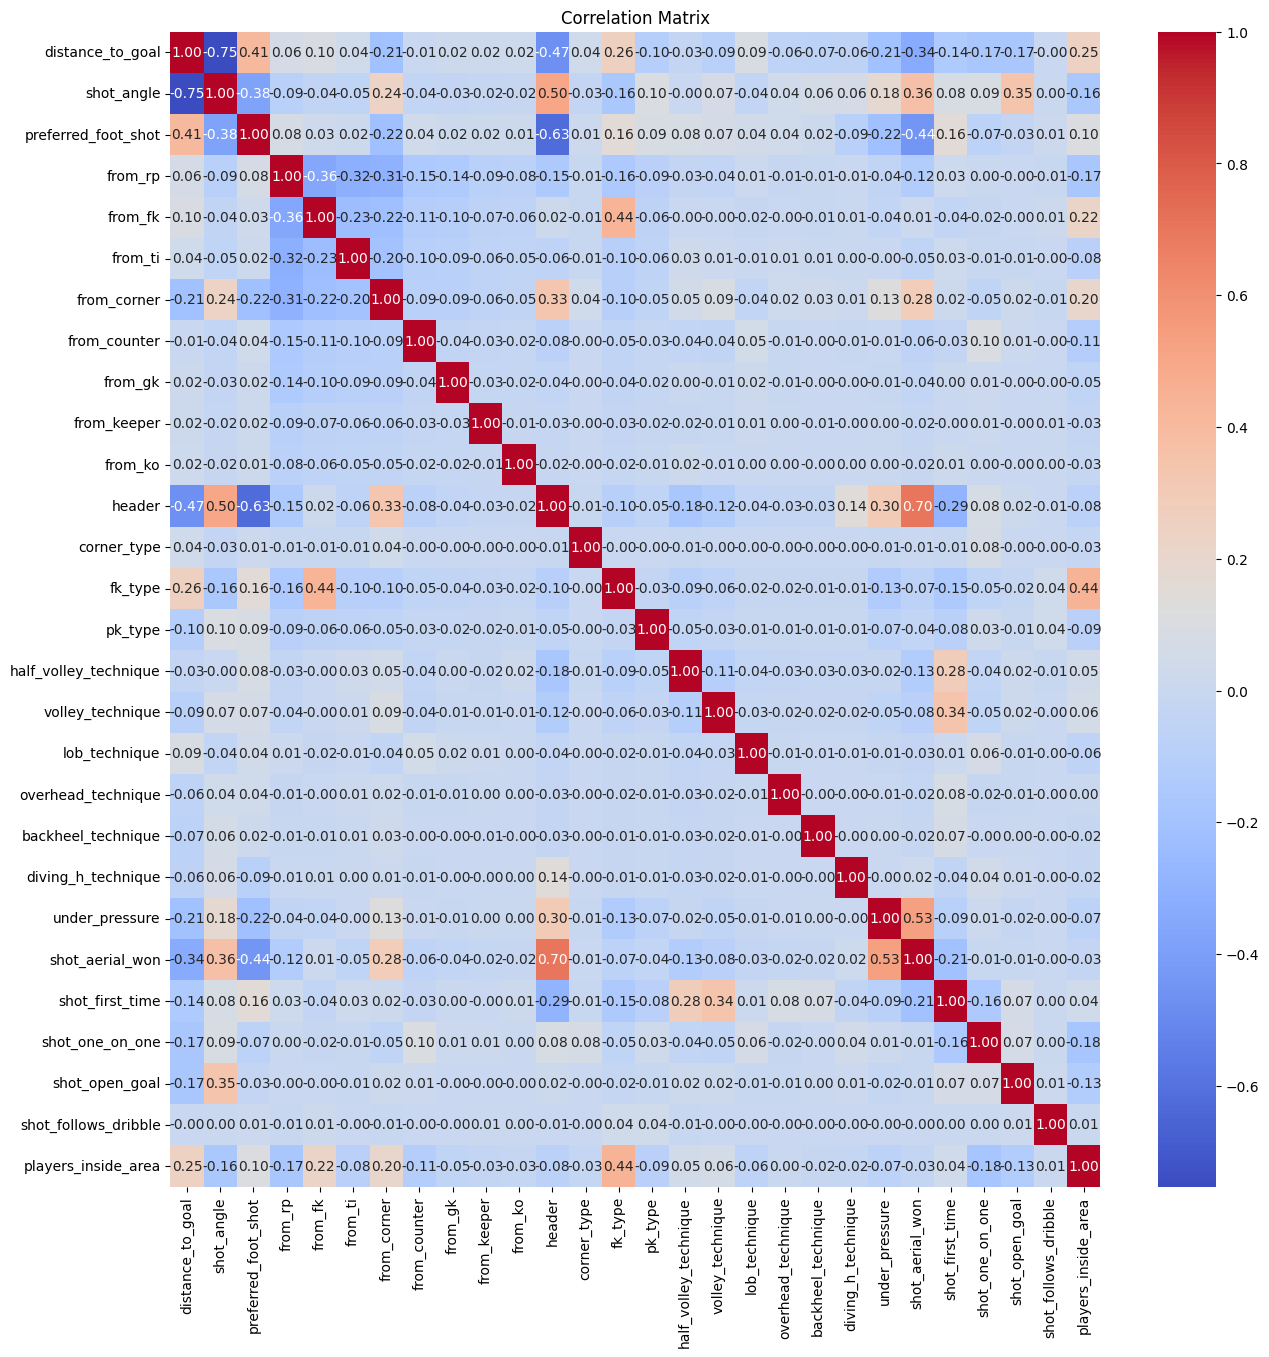

In [9]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=features, yticklabels=features)
plt.title("Correlation Matrix")
plt.show()

## Model Training

In [9]:
# splitting data
train_data, test_data = pp.pre_training(shots,train_size=0.7)

## Regression Logistique

### Training

In [10]:
start_time = time.time()
log_reg = ModelTrainer(train_data,test_data,model_type='logistic',max_iter=100)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

25/01/29 09:35:55 WARN TaskSetManager: Stage 28 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 09:36:47 WARN TaskSetManager: Stage 43 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 09:37:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/29 09:37:42 WARN TaskSetManager: Stage 238 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 09:38:29 WARN TaskSetManager: Stage 253 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 09:39:17 WARN TaskSetManager: Stage 268 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.


Training took 2564.11 seconds.


### Evaluation

In [12]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

25/01/29 08:44:10 WARN TaskSetManager: Stage 327 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:44:55 WARN TaskSetManager: Stage 349 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:45:43 WARN TaskSetManager: Stage 371 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:46:31 WARN TaskSetManager: Stage 393 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:47:14 WARN TaskSetManager: Stage 415 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:47:56 WARN TaskSetManager: Stage 437 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.
25/01/29 08:48:44 WARN TaskSetManager: Stage 459 contains a task of very large size (1681 KiB). The maximum recommended task size is 1000 KiB.

In [13]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.36,
 'Precision': 68.74,
 'Recall': 20.56,
 'Sensitivity': 20.56,
 'Specificity': 98.86,
 'F1': 31.66,
 'FPR': 1.14,
 'FNR': 79.44}

In [14]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 83.87,
 'Recall': 77.13,
 'Sensitivity': 77.13,
 'Specificity': 99.46,
 'F1': 80.35,
 'FPR': 0.54,
 'FNR': 22.87}

In [15]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.0037, 'RMSE': 0.06085, 'MAE': 0.03424, 'R2': 83.03}

In [ ]:
shot.withColumnRenamed('prediction','sb_prediction')

In [13]:
shot.show()

+------+---------+------------------+------------------+----------------+------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+-------------+----+
|    id|player_id|   shot_location_x|   shot_location_y|distance_to_goal|        shot_angle|preferred_foot_shot|from_rp|from_fk|from_corner|header|corner_type|fk_type|pk_type|lob_technique|shot_first_time|shot_one_on_one|shot_follows_dribble|players_inside_area|acrobatic_shot| shot_statsbomb_xg|sb_prediction|goal|
+------+---------+------------------+------------------+----------------+------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+-------------+----+
|155711|   4299.0|119.51999816894532|46.560000610351

In [14]:
import pyspark.sql.functions as F

In [30]:
tp = shot.filter((F.col('goal') == 1) & (F.col('sb_prediction') == 1)).count()

tn = shot.filter((F.col('goal') == 0) & (F.col('sb_prediction') == 0)).count()

fp = shot.filter((F.col('goal') == 0) & (F.col('sb_prediction') == 1)).count()

fn = shot.filter((F.col('goal') == 1) & (F.col('sb_prediction') == 0)).count()

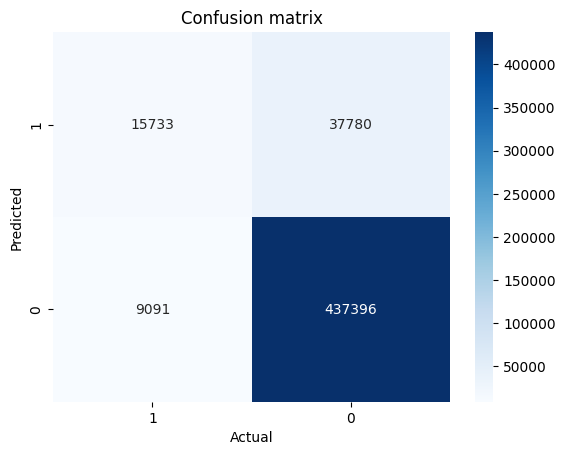

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def conf_matrix(tp,tn,fp,fn):
    cm = np.array([[tp,fn],[fp,tn]])
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['1','0'],
                yticklabels=['1','0'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    
conf_matrix(tp,tn,fp,fn)

In [16]:
# Feature importance
fi = log_reg.feature_importance()
fi.sort_values(by='Importance',ascending=False)

,Feature,Importance
11,pk_type,2.194412
9,corner_type,2.177720
10,fk_type,1.699249
14,lob_technique,0.895473
25,shot_open_goal,0.877785
17,diving_h_technique,0.725343
4,from_counter,0.534679
6,from_keeper,0.341311
20,preferred_foot_shot,0.308018
24,shot_one_on_one,0.269163


In [18]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [20]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [21]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [22]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

## Naive Bayes

In [39]:
start_time = time.time()
nb = ModelTrainer(train_data,test_data,model_type='nb')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took 746.4 seconds.")

Training took 746.4 seconds.


ROC-AUC for max_iter=10: 67.53%
ROC-AUC for max_iter=20: 67.53%
ROC-AUC for max_iter=30: 67.53%
ROC-AUC for max_iter=40: 67.53%
ROC-AUC for max_iter=50: 67.53%
ROC-AUC for max_iter=60: 67.53%
ROC-AUC for max_iter=70: 67.53%
ROC-AUC for max_iter=80: 67.53%
ROC-AUC for max_iter=90: 67.53%
ROC-AUC for max_iter=100: 67.53%


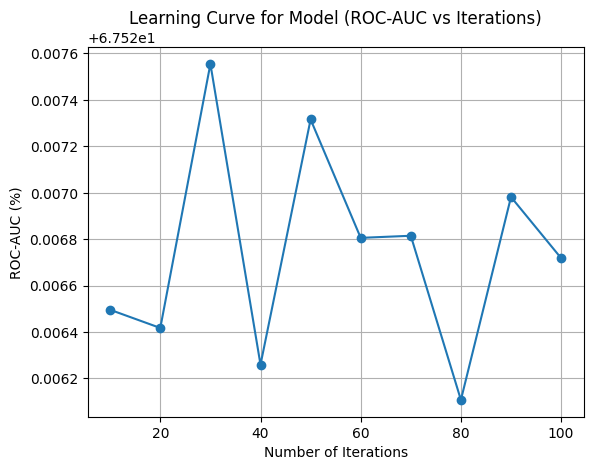

In [20]:
nb.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [59]:
predictions = nb.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 76.51,
 'Precision': 25.58,
 'Recall': 57.98,
 'Sensitivity': 57.98,
 'Specificity': 78.84,
 'F1': 35.5,
 'FPR': 21.16,
 'FNR': 42.02}

In [60]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 78.15,
 'Precision': 13.89,
 'Recall': 97.42,
 'Sensitivity': 97.42,
 'Specificity': 77.43,
 'F1': 24.31,
 'FPR': 22.57,
 'FNR': 2.58}

In [76]:
print('Regression results')
me_r.get_all_metrics()

Regression results

{'MSE': 0.14119, 'RMSE': 0.37575, 'MAE': 0.2193, 'R2': 542.53}


### Confirming that the model is not Overfitting

In [ ]:
nb = ModelTrainer(train_data,train_data,model_type='nb',max_iter=100)

ROC-AUC for max_iter=10: 66.78%
ROC-AUC for max_iter=20: 66.78%
ROC-AUC for max_iter=30: 66.78%
ROC-AUC for max_iter=40: 66.78%
ROC-AUC for max_iter=50: 66.78%
ROC-AUC for max_iter=60: 66.78%
ROC-AUC for max_iter=70: 66.78%
ROC-AUC for max_iter=80: 66.78%
ROC-AUC for max_iter=90: 66.78%
ROC-AUC for max_iter=100: 66.78%


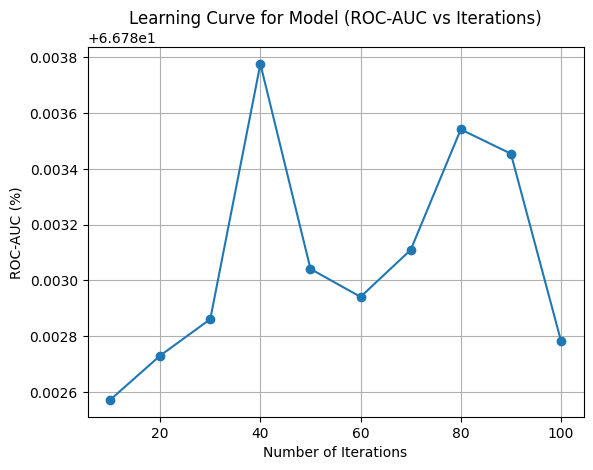

In [66]:
nb.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [63]:
predictions = nb.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 76.55,
 'Precision': 24.61,
 'Recall': 58.28,
 'Sensitivity': 58.28,
 'Specificity': 78.73,
 'F1': 34.61,
 'FPR': 21.27,
 'FNR': 41.72}

In [64]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 78.25,
 'Precision': 14.16,
 'Recall': 97.11,
 'Sensitivity': 97.11,
 'Specificity': 77.53,
 'F1': 24.71,
 'FPR': 22.47,
 'FNR': 2.89}

In [77]:
print('Regression results')
me_r.get_all_metrics()

Regression results

{'MSE': 0.13969, 'RMSE': 0.37375, 'MAE': 0.21764, 'R2': 522.02


## Decision Tree

In [41]:
start_time = time.time()
dt = ModelTrainer(train_data,test_data,model_type='dt')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 1213.8 seconds.


In [29]:
predictions = dt.predictions 
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [30]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 89.96,
 'Precision': 71.67,
 'Recall': 16.36,
 'Sensitivity': 16.36,
 'Specificity': 99.19,
 'F1': 26.63,
 'FPR': 0.81,
 'FNR': 83.64}

In [33]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.06,
 'Precision': 82.62,
 'Recall': 58.33,
 'Sensitivity': 58.33,
 'Specificity': 99.54,
 'F1': 68.38,
 'FPR': 0.46,
 'FNR': 41.67}

In [34]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00727, 'RMSE': 0.08526, 'MAE': 0.0484, 'R2': 66.92}

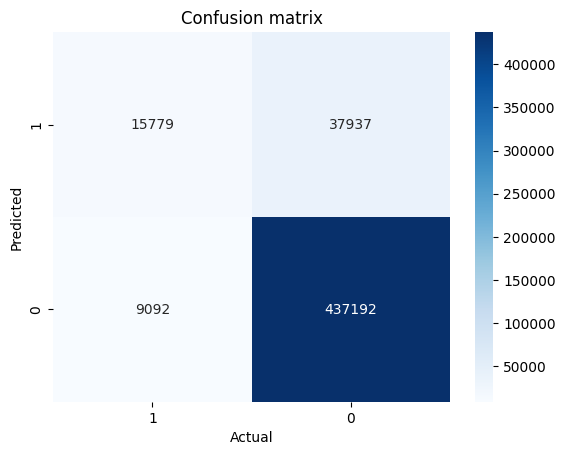

In [34]:
tp = shot.filter((F.col('goal') == 1) & (F.col('sb_prediction') == 1)).count()

tn = shot.filter((F.col('goal') == 0) & (F.col('sb_prediction') == 0)).count()

fp = shot.filter((F.col('goal') == 0) & (F.col('sb_prediction') == 1)).count()

fn = shot.filter((F.col('goal') == 1) & (F.col('sb_prediction') == 0)).count()

def conf_matrix(tp,tn,fp,fn):
    cm = np.array([[tp,fn],[fp,tn]])
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['1','0'],
                yticklabels=['1','0'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    
conf_matrix(tp,tn,fp,fn)

In [35]:
fi_dt = dt.feature_importance()
fi_dt.sort_values(by='Importance',ascending=False)

,Feature,Importance
19,shot_angle,0.394019
8,header,0.200981
18,distance_to_goal,0.117130
25,shot_open_goal,0.116713
11,pk_type,0.104172
24,shot_one_on_one,0.046879
22,shot_aerial_won,0.011056
3,from_corner,0.006698
27,players_inside_area,0.002352
1,from_fk,0.000000


In [ ]:
dt = ModelTrainer(train_data,train_data,model_type='dt',max_iter=60)

In [38]:
predictions = dt.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [40]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [41]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

## SVM

In [40]:
start_time = time.time()
svm = ModelTrainer(train_data,test_data,model_type='svm')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 1772.1 seconds.


ROC-AUC for max_iter=10: 76.19%
ROC-AUC for max_iter=20: 79.18%
ROC-AUC for max_iter=30: 76.67%
ROC-AUC for max_iter=40: 65.27%
ROC-AUC for max_iter=50: 67.49%
ROC-AUC for max_iter=60: 72.58%
ROC-AUC for max_iter=70: 74.31%
ROC-AUC for max_iter=80: 71.23%
ROC-AUC for max_iter=90: 67.38%
ROC-AUC for max_iter=100: 73.79%


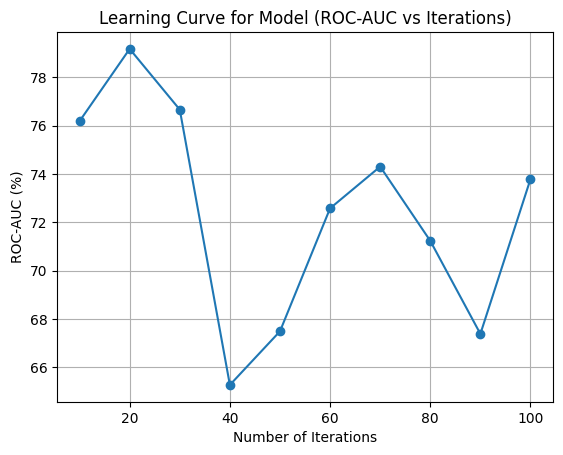

In [37]:
svm.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [48]:
predictions = svm.predictions
predictions = predictions.withColumnRenamed('rawPrediction','probability')
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [49]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.07,
 'Precision': 73.98,
 'Recall': 16.85,
 'Sensitivity': 16.85,
 'Specificity': 99.26,
 'F1': 27.44,
 'FPR': 0.74,
 'FNR': 83.15}

In [50]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.47,
 'Precision': 90.75,
 'Recall': 63.94,
 'Sensitivity': 63.94,
 'Specificity': 99.76,
 'F1': 75.02,
 'FPR': 0.24,
 'FNR': 36.06}

In [79]:
print('Regression results')
me_r.get_all_metrics()

Regression results

{'MSE': 1.16644, 'RMSE': 1.08002, 'MAE': 1.06679, 'R2': 5208.42}


In [52]:
fi_svm = svm.feature_importance()
fi_svm.sort_values(by='Importance',ascending=False)

,Feature,Importance
25,shot_open_goal,2.000000e+00
11,pk_type,1.968162e+00
9,corner_type,2.125180e-06
10,fk_type,9.281154e-07
20,preferred_foot_shot,3.849937e-07
14,lob_technique,2.877973e-07
21,under_pressure,1.510668e-07
8,header,3.423637e-08
23,shot_first_time,3.353126e-08
12,half_volley_technique,0.000000e+00


In [69]:
FEATURES = ['from_rp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique',
            'diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']

In [71]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Split data
train, test = shots.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

# Define evaluator for AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [72]:
lr = LogisticRegression(featuresCol="features", labelCol="goal")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC-ROC: {lr_auc}")

Logistic Regression AUC-ROC: 0.8040863485273682


In [73]:
nb = NaiveBayes(featuresCol="features", labelCol="goal")
nb_model = nb.fit(train)
nb_predictions = nb_model.transform(test)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Naïve Bayes AUC-ROC: {nb_auc}")

Naïve Bayes AUC-ROC: 0.6749610726643598


In [74]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="goal")
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC-ROC: {dt_auc}")

Decision Tree AUC-ROC: 0.5330984524425797


In [75]:
svm = LinearSVC(featuresCol="features", labelCol="goal", maxIter=10)
svm_model = svm.fit(train)
svm_predictions = svm_model.transform(test)
svm_auc = evaluator.evaluate(svm_predictions)
print(f"SVM AUC-ROC: {svm_auc}")

SVM AUC-ROC: 0.748943887420647


In [ ]:
spark.stop()